In [8]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

In [4]:
# Load the dataset
orders_df = pd.read_csv('../data/Dataset.csv', encoding='Windows-1252')

# Prepare the data
orders_df['Order Date'] = pd.to_datetime(orders_df['Order Date'], format="%d/%m/%Y")
orders_df['day_of_week'] = orders_df['Order Date'].dt.dayofweek

# Function to train and predict for each sub-category
def train_and_predict_for_sub_category(sub_category):
    sub_cat_data = orders_df[orders_df['Sub-Category'] == sub_category]
    sales_data = sub_cat_data.groupby('Order Date').agg({'Sales': 'sum', 'Discount': 'mean', 'Profit': 'mean', 'day_of_week': 'mean'}).reset_index()
    sales_data.columns = ['ds', 'y', 'discount', 'profit', 'day_of_week']

    # Train-test split
    train, test = train_test_split(sales_data, test_size=0.2, shuffle=False)

    # Train the Prophet model with additional regressors
    model = Prophet(interval_width=0.95, seasonality_mode='multiplicative', daily_seasonality=True)
    model.add_regressor('discount')
    model.add_regressor('profit')
    # model.add_regressor('day_of_week')
    model.fit(train)

    # Make future dataframe for prediction
    future = model.make_future_dataframe(periods=len(test), freq='D')
    future['discount'] = pd.concat([train['discount'], test['discount']])
    future['profit'] = pd.concat([train['profit'], test['profit']])
    future['day_of_week'] = future['ds'].dt.dayofweek

    # Predict
    forecast = model.predict(future)

    # Merge actual and forecasted values
    test_data = test.set_index('ds')
    forecast = forecast.set_index('ds')
    predicted = forecast[['yhat']].iloc[-len(test_data):]
    merged_df = test_data.join(predicted, how='inner')
    
    return merged_df

# Get unique sub-categories
sub_categories = orders_df['Sub-Category'].unique()

16:52:58 - cmdstanpy - INFO - Chain [1] start processing
16:52:59 - cmdstanpy - INFO - Chain [1] done processing
16:52:59 - cmdstanpy - INFO - Chain [1] start processing
16:52:59 - cmdstanpy - INFO - Chain [1] done processing
16:53:00 - cmdstanpy - INFO - Chain [1] start processing
16:53:00 - cmdstanpy - INFO - Chain [1] done processing
16:53:00 - cmdstanpy - INFO - Chain [1] start processing
16:53:00 - cmdstanpy - INFO - Chain [1] done processing
16:53:01 - cmdstanpy - INFO - Chain [1] start processing
16:53:01 - cmdstanpy - INFO - Chain [1] done processing
16:53:01 - cmdstanpy - INFO - Chain [1] start processing
16:53:01 - cmdstanpy - INFO - Chain [1] done processing
16:53:02 - cmdstanpy - INFO - Chain [1] start processing
16:53:02 - cmdstanpy - INFO - Chain [1] done processing
16:53:02 - cmdstanpy - INFO - Chain [1] start processing
16:53:02 - cmdstanpy - INFO - Chain [1] done processing
16:53:03 - cmdstanpy - INFO - Chain [1] start processing
16:53:03 - cmdstanpy - INFO - Chain [1]

16:57:29 - cmdstanpy - INFO - Chain [1] start processing
16:57:29 - cmdstanpy - INFO - Chain [1] done processing
/Users/linusrandud/.pyenv/versions/GhostPostCC/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
16:57:30 - cmdstanpy - INFO - Chain [1] start processing
16:57:30 - cmdstanpy - INFO - Chain [1] done processing
/Users/linusrandud/.pyenv/versions/GhostPostCC/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
16:57:30 - cmdstanpy - INFO - Chain [1] start processing
16:57:30 - cmdstanpy - INFO - Chain [1] done processing
/Users/linusrandud/.pyenv/versions/GhostPostCC/lib/python3.10/site-pa

Overall MSE: 921.2962
Overall RMSPE: 13.6566
Overall MAPE: 5.7251


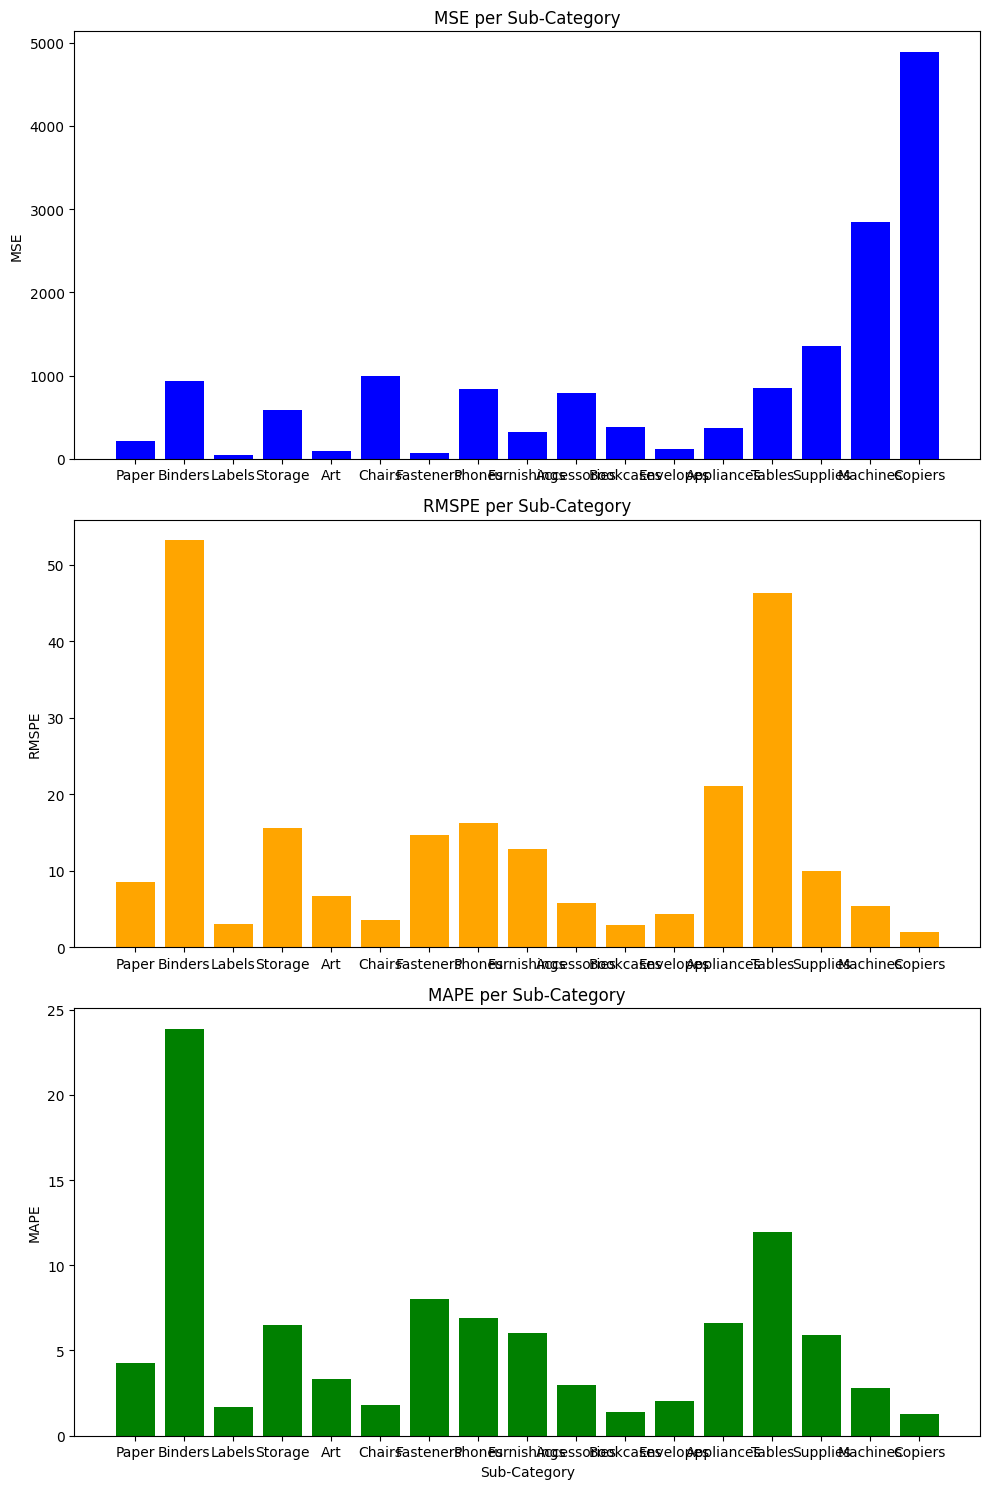

In [9]:
# Dictionary to store results for each sub-category
results = {}

# Lists to store metrics
mse_list = []
rmspe_list = []
mape_list = []

# Function to calculate RMSPE
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

for sub_category in sub_categories:
    merged_df = train_and_predict_for_sub_category(sub_category)
    mse = mean_squared_error(merged_df['y'], merged_df['yhat'], squared=False)
    rmspe_value = rmspe(merged_df['y'], merged_df['yhat'])
    mape = mean_absolute_percentage_error(merged_df['y'], merged_df['yhat'])
    
    mse_list.append(mse)
    rmspe_list.append(rmspe_value)
    mape_list.append(mape)
    
    results[sub_category] = {
        'data': merged_df,
        'mse': mse,
        'rmspe': rmspe_value,
        'mape': mape
    }

# Calculate overall metrics
overall_mse = np.mean(mse_list)
overall_rmspe = np.mean(rmspe_list)
overall_mape = np.mean(mape_list)

print(f'Overall MSE: {overall_mse:.4f}')
print(f'Overall RMSPE: {overall_rmspe:.4f}')
print(f'Overall MAPE: {overall_mape:.4f}')

# Plot the results
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

axes[0].bar(results.keys(), mse_list, color='blue')
axes[0].set_title('MSE per Sub-Category')
axes[0].set_ylabel('MSE')

axes[1].bar(results.keys(), rmspe_list, color='orange')
axes[1].set_title('RMSPE per Sub-Category')
axes[1].set_ylabel('RMSPE')

axes[2].bar(results.keys(), mape_list, color='green')
axes[2].set_title('MAPE per Sub-Category')
axes[2].set_ylabel('MAPE')
axes[2].set_xlabel('Sub-Category')

plt.tight_layout()
plt.show()